## Initialisations

In [1]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [3]:
url='https://drive.google.com/file/d/1Fsl9G_C7ZzRn0VpfpF8CjuXkdC18Y6Vf/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
compas_df = pd.read_csv(url, sep=',')

## Preprocessing

In [4]:
compas_df['DateOfBirth'] = compas_df['DateOfBirth'].str[6:]
compas_df['DateOfBirth'] = pd.to_numeric(compas_df['DateOfBirth'])
compas_df['DateOfBirth'] = compas_df['DateOfBirth'] + 1900

In [5]:
compas_df["Age"] = 2016 - compas_df["DateOfBirth"]

In [6]:
compas_df['ScoreText'].replace('High', 'Medium_High', inplace=True)
compas_df['ScoreText'].replace('Medium', 'Medium_High', inplace=True)

In [7]:
compas_df = compas_df.drop(columns=["Person_ID","AssessmentID","Case_ID","FirstName","MiddleName","LastName","DateOfBirth","ScaleSet_ID","Screening_Date","AssessmentReason","RecSupervisionLevel","Scale_ID","IsCompleted","IsDeleted"])

In [8]:
compas_df = compas_df.drop(columns=["DecileScore","RecSupervisionLevelText","RawScore"])

In [9]:
compas_df = compas_df.dropna()

In [10]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Unknown']

In [11]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Other']

In [12]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Oriental']

In [13]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Arabic']

In [14]:
compas_df['Ethnic_Code_Text'].replace('African-Am', 'African-American', inplace=True)

## Label Encoder

In [15]:
le = LabelEncoder()
compas_df.Agency_Text = le.fit_transform(compas_df.Agency_Text)
compas_df.Sex_Code_Text = le.fit_transform(compas_df.Sex_Code_Text)
compas_df.Ethnic_Code_Text = le.fit_transform(compas_df.Ethnic_Code_Text)
compas_df.ScaleSet = le.fit_transform(compas_df.ScaleSet)
compas_df.Language = le.fit_transform(compas_df.Language)
compas_df.LegalStatus = le.fit_transform(compas_df.LegalStatus)
compas_df.CustodyStatus = le.fit_transform(compas_df.CustodyStatus)
compas_df.MaritalStatus = le.fit_transform(compas_df.MaritalStatus)
compas_df.DisplayText = le.fit_transform(compas_df.DisplayText)
compas_df.ScoreText = le.fit_transform(compas_df.ScoreText)
compas_df.AssessmentType = le.fit_transform(compas_df.AssessmentType)

In [16]:
# Disproportionate sampling of the target group:
# randomly select 17500 samples from each stratum of the score target group
compas_df_sample = compas_df.groupby('ScoreText', group_keys=False).apply(lambda x: x.sample(17500))

In [17]:
# check the sample takes an even number of cases from each strata of the target variable
(compas_df_sample['ScoreText'].value_counts()) / len(compas_df_sample) * 100

0    50.0
1    50.0
Name: ScoreText, dtype: float64

In [18]:
for col in compas_df_sample:
    compas_df = compas_df[compas_df[col] != 'Unknown']

## Test Train Split

In [19]:
X = compas_df_sample.drop('ScoreText',axis=1)
y = compas_df_sample[['ScoreText']]

K-Fold

In [20]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [21]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(23334, 11)
Test data shape:(11666, 11)


Scaling data

In [22]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

## Decision Tree Model

In [23]:
dt = DecisionTreeClassifier()

In [24]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [25]:
pred = dt.predict(scaled_test)

In [26]:
dt_model_accuracy = accuracy_score(y_test,pred)
dt_model_accuracy

0.6775244299674267

In [27]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [28]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [29]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [30]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=8,
                                   max_features = None,
                                   min_samples_leaf=10,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, random_state=0)

In [31]:
pred = dt_tuned.predict(scaled_test)

In [32]:
dt_tuned_model_accuracy = accuracy_score(y_test,pred)
dt_tuned_model_accuracy

0.7010114863706498

In [33]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      5833
           1       0.69      0.72      0.71      5833

    accuracy                           0.70     11666
   macro avg       0.70      0.70      0.70     11666
weighted avg       0.70      0.70      0.70     11666



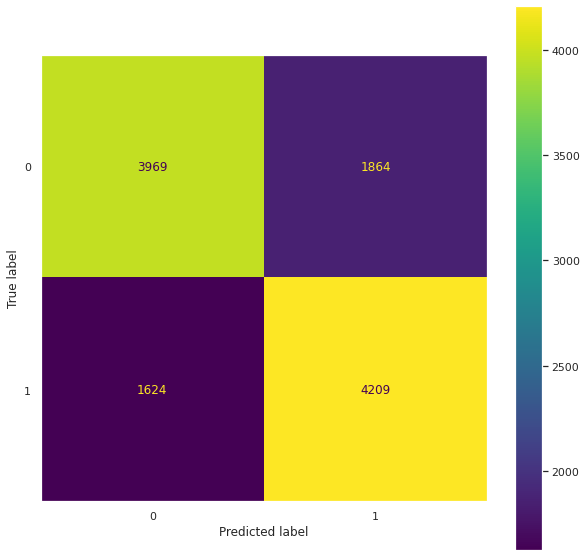

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

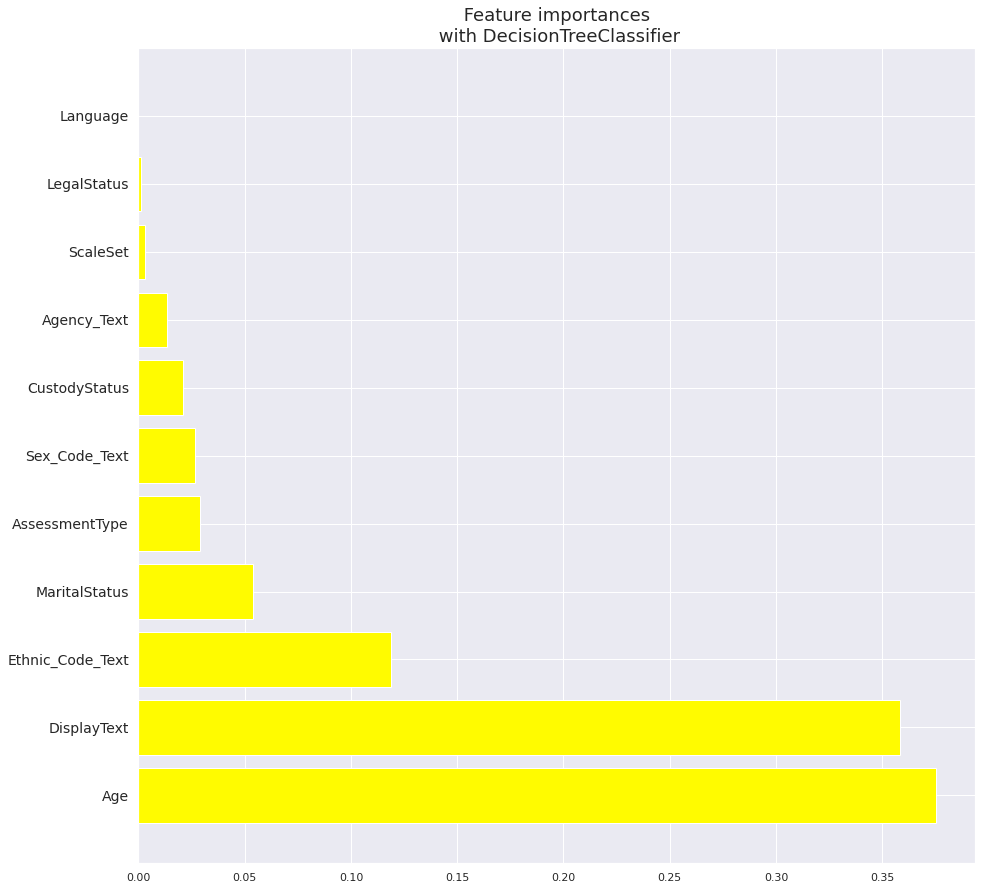

In [35]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

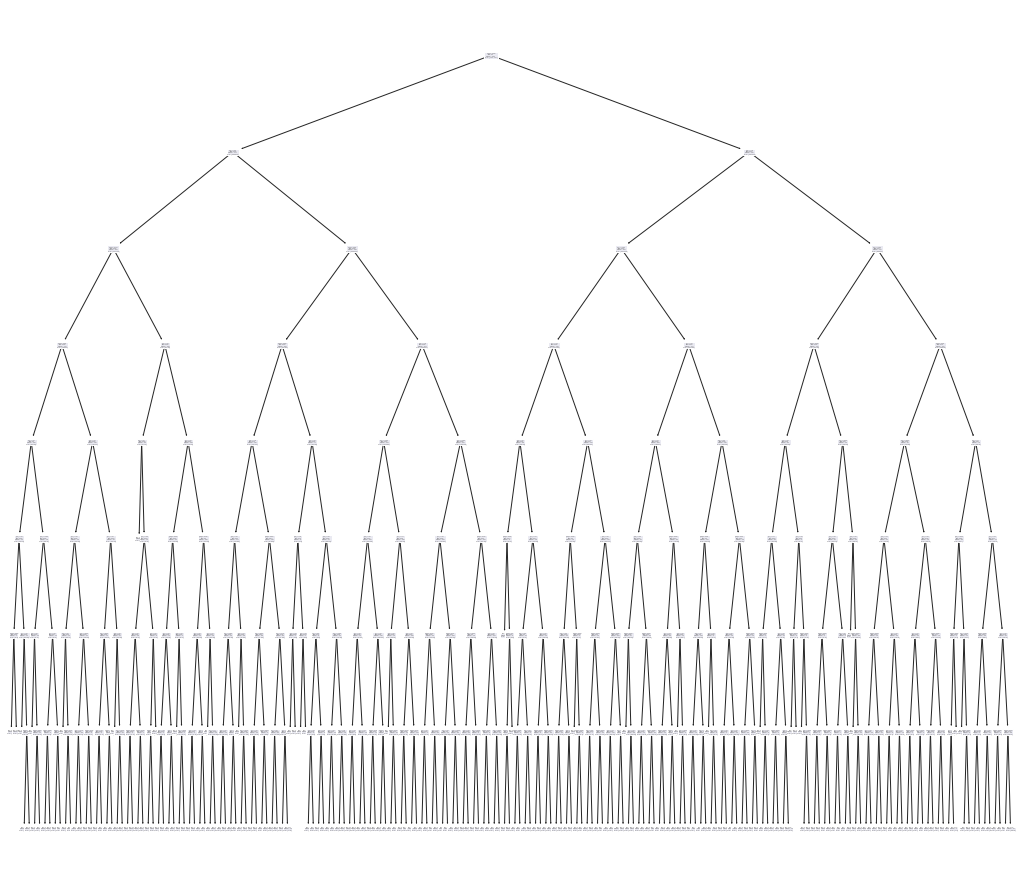

In [36]:
plt.figure(figsize = (18, 16))
tree.plot_tree(dt_tuned)
plt.show()

In [37]:
ethnic_results = pd.DataFrame(data = x_test, columns=['Ethnic_Code_Text'])
ethnic_results['y_test'] = y_test
ethnic_results['pred'] = pred

In [38]:
ethnic_results['y_test'].replace(0, 'High/Medium', inplace=True)
ethnic_results['y_test'].replace(1, 'Low', inplace=True)
ethnic_results['pred'].replace(0, 'High/Medium', inplace=True)
ethnic_results['pred'].replace(1, 'Low', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(0, 'African_American', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(1, 'Asian', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(2, 'Caucasian', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(3, 'Hispanic', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(4, 'Native_American', inplace=True)

ethnic_results.head()

,Ethnic_Code_Text,y_test,pred
9942,Caucasian,High/Medium,High/Medium
58850,African_American,High/Medium,Low
1823,African_American,High/Medium,Low
1656,Hispanic,High/Medium,High/Medium
24824,Caucasian,High/Medium,High/Medium


In [39]:
ethnic_results_cauc = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Caucasian']
ethnic_results_cauc['true']  = np.where((ethnic_results_cauc['y_test'] == ethnic_results_cauc['pred']), 1, 0)
cauc_accuracy = (sum(ethnic_results_cauc['true'])/ethnic_results_cauc.shape[0])*100
cauc_accuracy

68.92722117202268

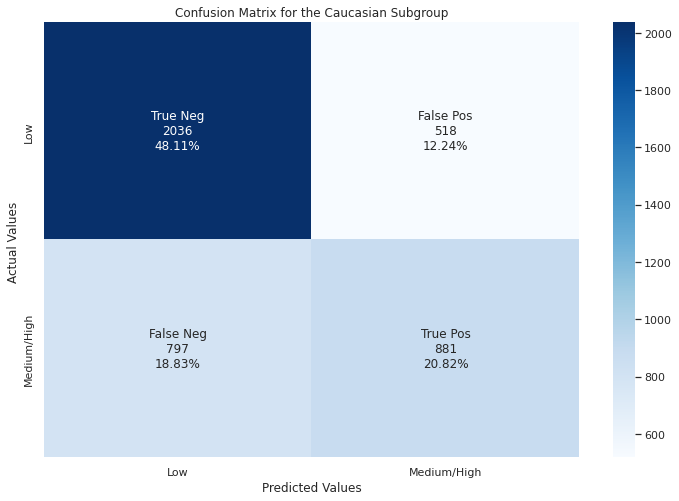

In [40]:
y_test = ethnic_results_cauc['y_test']
pred = ethnic_results_cauc['pred']
cauc_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cauc_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cauc_cf.flatten()/np.sum(cauc_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cauc_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Caucasian Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

plt.show()

In [41]:
ethnic_results_afr = ethnic_results[ethnic_results['Ethnic_Code_Text']=='African_American']
ethnic_results_afr['true']  = np.where((ethnic_results_afr['y_test'] == ethnic_results_afr['pred']), 1, 0)
afr_accuracy = (sum(ethnic_results_afr['true'])/ethnic_results_afr.shape[0])*100
afr_accuracy

70.78333333333333

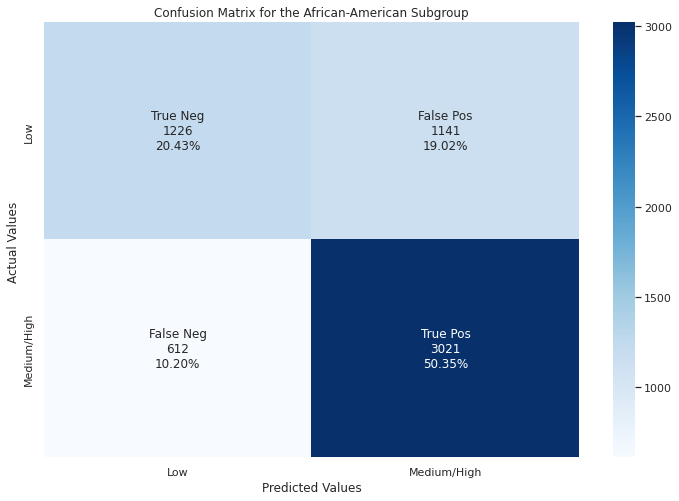

In [42]:
y_test = ethnic_results_afr['y_test']
pred = ethnic_results_afr['pred']
afr_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                afr_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     afr_cf.flatten()/np.sum(afr_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(afr_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the African-American Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

plt.show()

In [43]:
ethnic_results_his = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Hispanic']
ethnic_results_his['true']  = np.where((ethnic_results_his['y_test'] == ethnic_results_his['pred']), 1, 0)
his_accuracy = (sum(ethnic_results_his['true'])/ethnic_results_his.shape[0])*100
his_accuracy

71.28053293856402

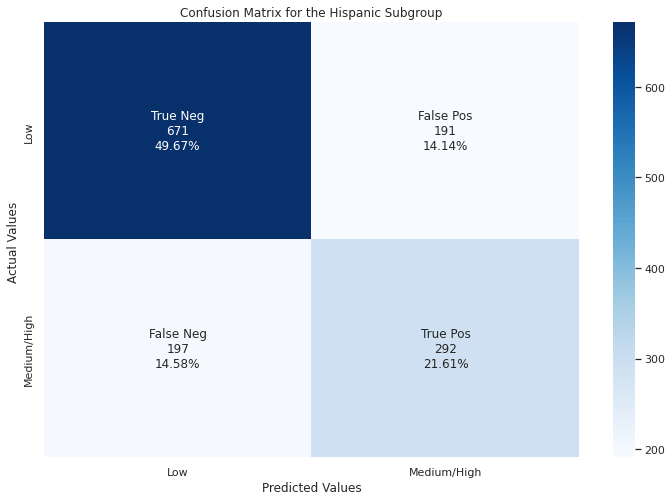

In [44]:
y_test = ethnic_results_his['y_test']
pred = ethnic_results_his['pred']
his_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                his_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     his_cf.flatten()/np.sum(his_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(his_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Hispanic Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

plt.show()

In [45]:
ethnic_results_asi = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Asian']
ethnic_results_asi['true']  = np.where((ethnic_results_asi['y_test'] == ethnic_results_asi['pred']), 1, 0)
asi_accuracy = (sum(ethnic_results_asi['true'])/ethnic_results_asi.shape[0])*100
asi_accuracy

72.5

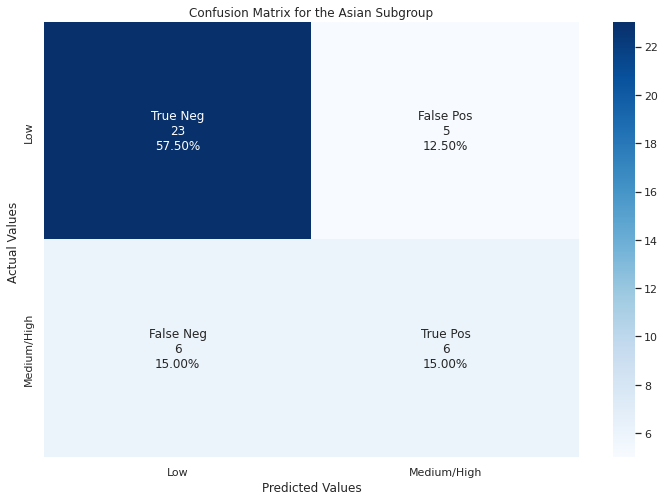

In [46]:
y_test = ethnic_results_asi['y_test']
pred = ethnic_results_asi['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Asian Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

plt.show()

In [47]:
# create a dataframe of only native american predicted and true values
#ethnic_results_nat = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Native_American']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
#ethnic_results_nat['true']  = np.where((ethnic_results_nat['y_test'] == ethnic_results_nat['pred']), 1, 0)
# calculate percentage of correct classifications
#nat_accuracy = (sum(ethnic_results_nat['true'])/ethnic_results_nat.shape[0])*100
#nat_accuracy

In [48]:
from tabulate import tabulate
data = [['Caucasian', cauc_accuracy],
['African-American', afr_accuracy],
['Hispanic', his_accuracy],
['Asian', asi_accuracy],
#['Native-American', nat_accuracy],
]
print (tabulate(data, headers=["Ethnicity", "Classification Accuracy"]))

Ethnicity           Classification Accuracy
----------------  -------------------------
Caucasian                           68.9272
African-American                    70.7833
Hispanic                            71.2805
Asian                               72.5
